In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Getting Data  and Exploratory analysis

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fraud analytics/Payments.csv")

In [5]:
data

,Sender,Receiver,Amount
0,1309,1011,123051
1,1309,1011,118406
2,1309,1011,112456
3,1309,1011,120593
4,1309,1011,166396
...,...,...,...
130530,1344,1390,21739
130531,1914,1390,3374
130532,1914,1390,5186
130533,1914,1390,1559


In [6]:
data.head()

,Sender,Receiver,Amount
0,1309,1011,123051
1,1309,1011,118406
2,1309,1011,112456
3,1309,1011,120593
4,1309,1011,166396


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130535 entries, 0 to 130534
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   Sender    130535 non-null  int64
 1   Receiver  130535 non-null  int64
 2   Amount    130535 non-null  int64
dtypes: int64(3)
memory usage: 3.0 MB


In [8]:
data.describe()

,Sender,Receiver,Amount
count,130535.000000,130535.000000,1.305350e+05
mean,1309.358287,1182.851258,6.980968e+04
std,294.435026,169.809657,5.696676e+04
min,1001.000000,1001.000000,1.501000e+03
25%,1078.000000,1060.000000,2.411100e+04
50%,1214.000000,1112.000000,5.622000e+04
75%,1488.000000,1276.000000,1.079405e+05
max,2190.000000,1887.000000,2.124500e+06


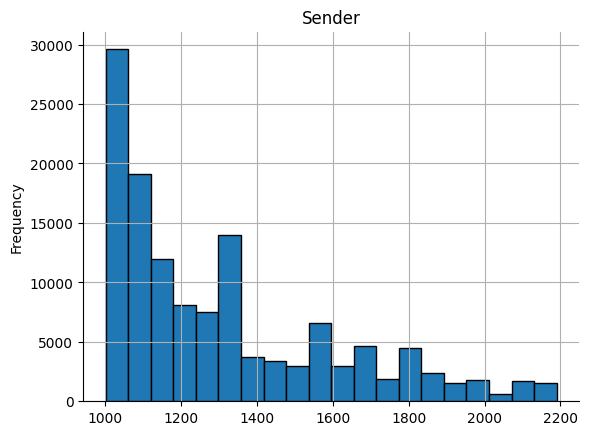

In [9]:
data['Sender'].plot(kind='hist', bins=20, title='Sender', edgecolor='black')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.grid(axis='both')

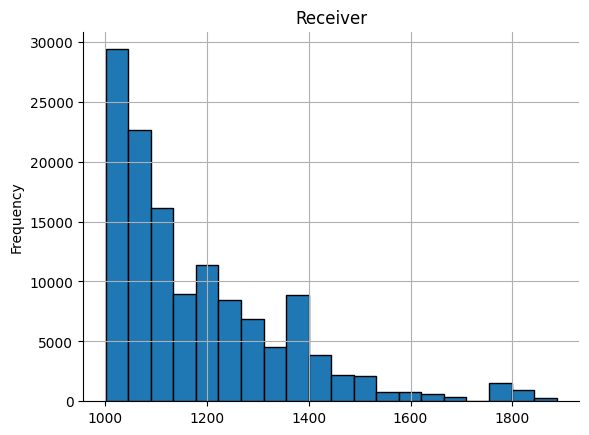

In [10]:
from matplotlib import pyplot as plt
data['Receiver'].plot(kind='hist', bins=20, title='Receiver',edgecolor='black')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.grid(axis='both')

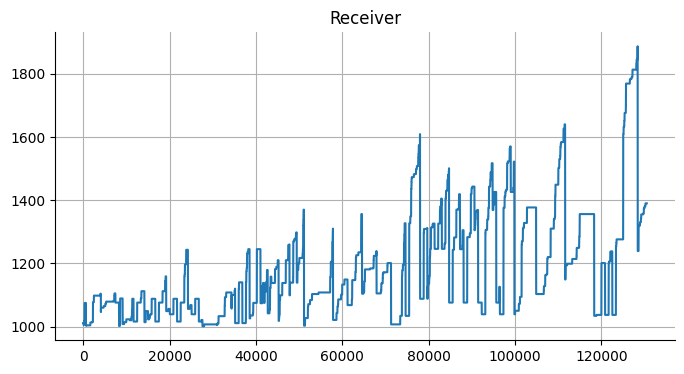

In [11]:
from matplotlib import pyplot as plt
data['Receiver'].plot(kind='line', figsize=(8, 4), title='Receiver')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(axis='both')

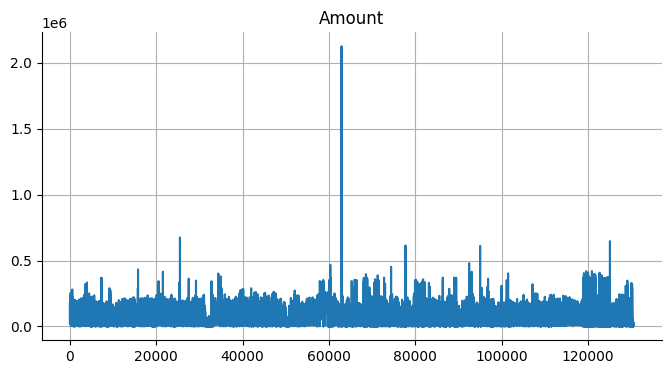

In [12]:
from matplotlib import pyplot as plt
data['Amount'].plot(kind='line', figsize=(8, 4), title='Amount')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(axis='both')

In [13]:
data.value_counts()

Sender  Receiver  Amount
1778    1103      5400      357
1104    1013      8060      125
1226    1249      5415      120
1142    1214      15500     117
1437    1609      3373       60
                           ... 
1096    1007      116245      1
                  115597      1
                  114019      1
                  111007      1
2190    1356      56061       1
Name: count, Length: 122614, dtype: int64

### Make Graph network for the data

In [14]:
#add one column of time that denotes the time at which payment was done
# data['Time'] = data.index

In [15]:
data.columns

Index(['Sender', 'Receiver', 'Amount'], dtype='object')

True


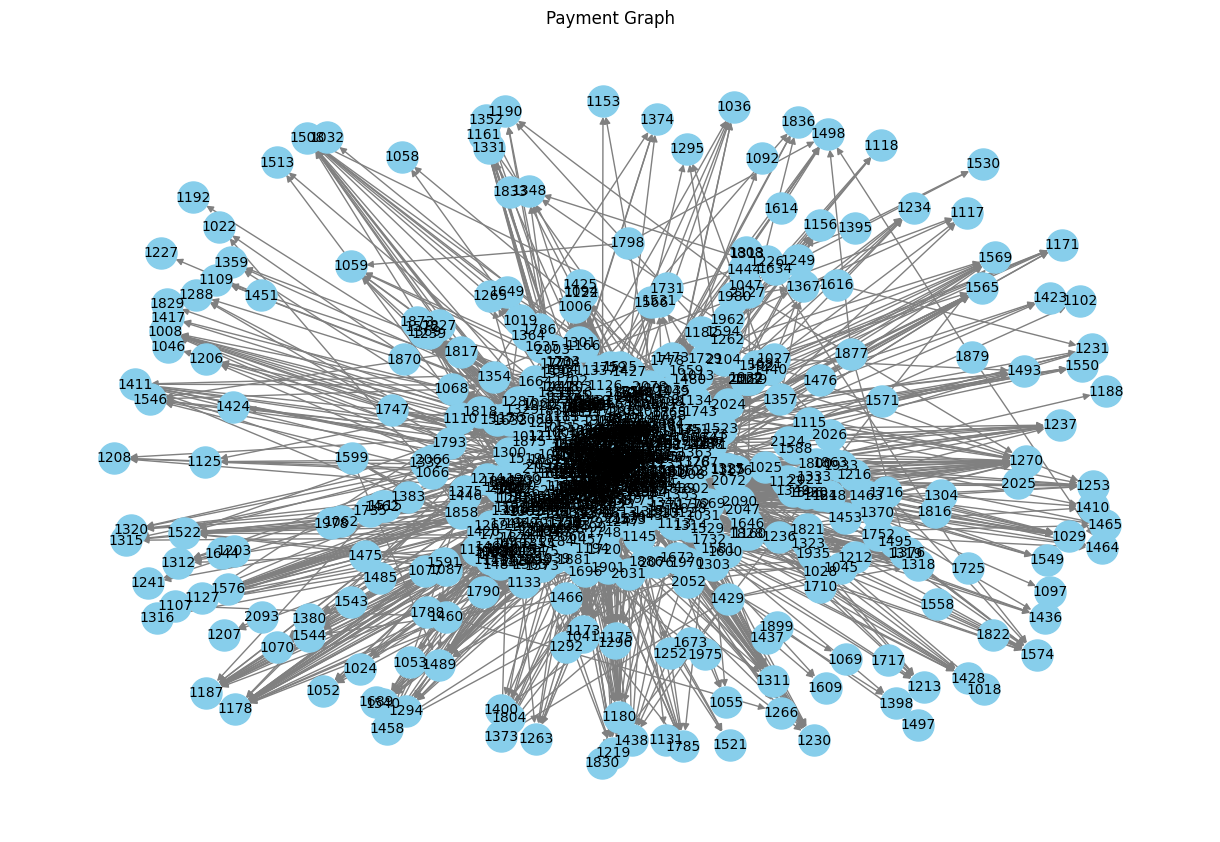

In [16]:
import networkx as nx

# Create a new graph
G = nx.DiGraph(name='payment graph')
print(G.is_directed())

for idx, row in data.iterrows():
    source = row['Sender']
    target = row['Receiver']
    weight = row['Amount']
    G.add_edge(source, target, weight=weight)


# Use a layout that spaces out the nodes more
pos = nx.spring_layout(G, k=0.40, iterations=20)

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='grey', node_size=500, font_size=10, width=1)
plt.title('Payment Graph')
plt.show()


In [17]:
print(f"Number of nodes in the graph:{G.number_of_nodes()}")
print(f"Number of edges in the graph: {G.number_of_edges()}")
total_weight = sum(data['weight'] for u, v, data in G.edges(data=True))
print("Total weight of all edges:", total_weight)


Number of nodes in the graph:799
Number of edges in the graph: 5358
Total weight of all edges: 306671493


Let's visualize the neighbourhoods of few nodes,

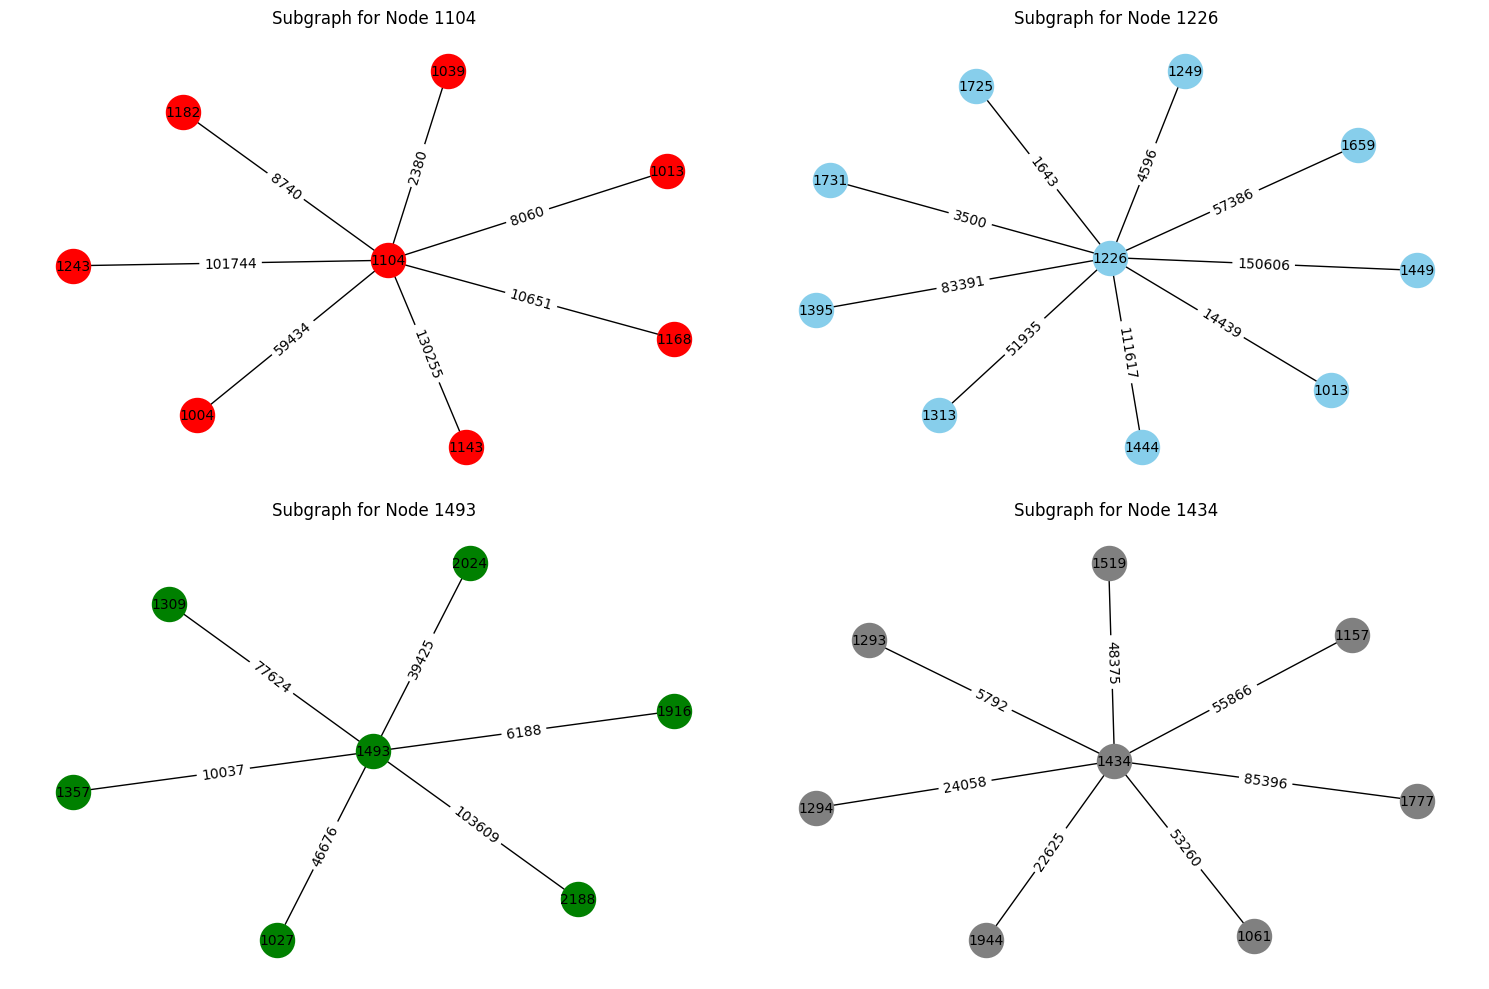

In [18]:
nodes_of_interest = [1104, 1226, 1493, 1434]
colors = ['red', 'skyblue', 'green', 'grey']

filtered_edges = data[(data['Sender'].isin(nodes_of_interest)) | (data['Receiver'].isin(nodes_of_interest))]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, node in enumerate(nodes_of_interest):
    # Create a subgraph with the filtered edges for the current node
    subgraph = nx.from_pandas_edgelist(filtered_edges[(filtered_edges['Sender'] == node) | (filtered_edges['Receiver'] == node)], source='Sender', target='Receiver', edge_attr='Amount')

    pos_subgraph = nx.spring_layout(subgraph)

    row = i // 2
    col = i % 2
    nx.draw(subgraph, pos_subgraph,arrows=True, with_labels=True, node_color=colors[i], node_size=600, font_size=10, width=1, ax=axs[row][col])
    nx.draw_networkx_edge_labels(subgraph, pos_subgraph, edge_labels=nx.get_edge_attributes(subgraph, 'Amount'), ax=axs[row][col])
    axs[row][col].set_title(f'Subgraph for Node {node}')

plt.tight_layout()
plt.show()


### Implement Node2Vec

In [19]:
!pip install node2vec

#### 3.1 Node2Vec for a randomly generated graph

Text(0.5, 1.0, 'Random Graph')

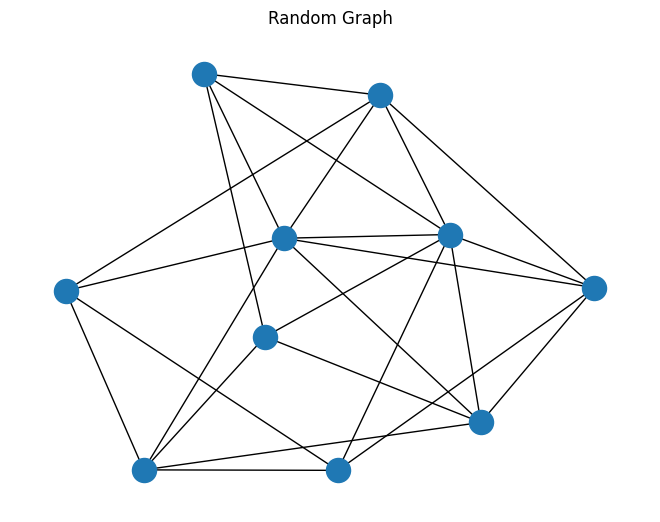

In [20]:
import networkx as nx
from node2vec import Node2Vec

graph = nx.fast_gnp_random_graph(n=10, p=0.5) #p is prob that their exists an edge between any pair
pos = nx.spring_layout(graph)
nx.draw(graph, pos)
plt.title("Random Graph")

In [21]:
node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4)

model = node2vec.fit(window=10, min_count=1, batch_words=4)

embeddings = model.wv #get all the embedded vectors

model.wv.most_similar('2') #get most similar nodes for node=2

Computing transition probabilities:   0%|          | 0/10 [00:00<?, ?it/s]

[('3', 0.9469789862632751),
 ('8', 0.9287660717964172),
 ('1', 0.9266949892044067),
 ('9', 0.9224106669425964),
 ('4', 0.9145809412002563),
 ('6', 0.909914493560791),
 ('7', 0.885223388671875),
 ('5', 0.8677241206169128),
 ('0', 0.7808545231819153)]

Above table is the probability that a node is similar to the node `2`.
Let's visualize the node embeddings on a plot.

In [22]:
embeddings.key_to_index

{'8': 0,
 '9': 1,
 '2': 2,
 '1': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '0': 8,
 '7': 9}

In [23]:
print(embeddings['4'].shape) #embedding vector dim
embeddings['4']

(64,)


array([-0.08683834, -0.19841169,  0.20746922,  0.19587423, -0.10423215,
       -0.21125948,  0.10406953,  0.00201562, -0.19151498, -0.13463204,
        0.19781794,  0.04828431, -0.09305498, -0.09849757,  0.11527361,
        0.04868117,  0.024369  ,  0.00365663, -0.0256086 ,  0.17602006,
        0.06353083,  0.11269394,  0.13561957,  0.02616938,  0.18413784,
        0.14481044,  0.00292738,  0.05077904, -0.05045846, -0.05369643,
        0.03501128, -0.15669052, -0.2109413 , -0.2587298 , -0.007041  ,
        0.06742632, -0.00201045,  0.04031404,  0.28469348, -0.05163709,
        0.05446714,  0.15990745,  0.05411718, -0.08404263,  0.09478462,
       -0.16507895,  0.02615103, -0.01174594,  0.10675567, -0.12573768,
        0.23235774, -0.09987192, -0.03629725,  0.21407028,  0.07003322,
       -0.06777246, -0.17842743, -0.1059428 , -0.073176  ,  0.16244619,
        0.00144515, -0.05310388, -0.08469436,  0.05320842], dtype=float32)

In [24]:
keys = list(embeddings.key_to_index.keys())
keys

['8', '9', '2', '1', '3', '4', '5', '6', '0', '7']

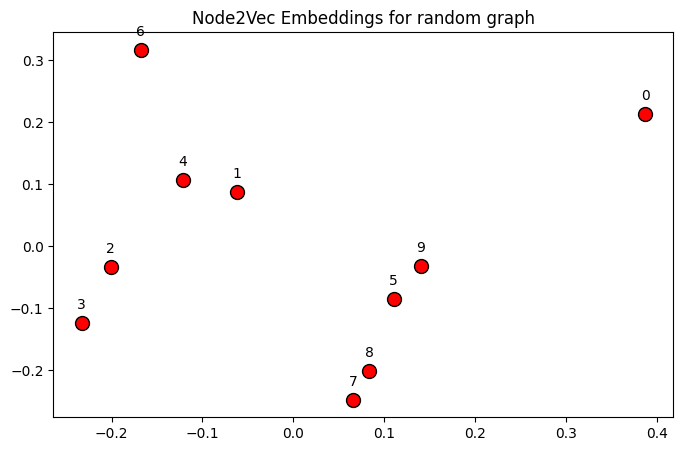

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

keys = list(embeddings.key_to_index.keys())
node_embeddings = [embeddings[key] for key in keys]

# Dimensionality Reduction with PCA
pca = PCA(n_components=3)
node_embeddings_2d = pca.fit_transform(node_embeddings)

# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], s=100, color='red',edgecolors='black')

for i, key in enumerate(keys):
    plt.annotate(key, (node_embeddings_2d[i, 0], node_embeddings_2d[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Node2Vec Embeddings for random graph')
plt.show()


Note that, node `8` is closer to node `2` than node `4`. This is what predicted by `model.wv.most_similar()`.

In [26]:
model.wv.most_similar('7', topn=5)

[('8', 0.9754422307014465),
 ('9', 0.9222589731216431),
 ('1', 0.9204774498939514),
 ('3', 0.9062148928642273),
 ('5', 0.900735080242157)]

#### 3.2 Node2Vec for `Payment Graph`

#### `p=1` and `q=1`

In [27]:
from node2vec import Node2Vec
#Hyper-Params
embedding_dim = 64
walk_length = 50
num_walks = 100
p = 10
q = 1

#perform node2vec embedding
node2vec_1 = Node2Vec(G, dimensions=embedding_dim, walk_length=walk_length, num_walks=num_walks, workers=4, p=p, q=q)
model_1 = node2vec_1.fit(window=10, min_count=1, batch_words=4)
node_embeddings_1 = model_1.wv #get all the embedded vectors

# model_1.wv.most_similar() #get most similar nodes for node

Computing transition probabilities:   0%|          | 0/799 [00:00<?, ?it/s]

In [28]:
node_embeddings_1.most_similar('1528', topn=5)

[('1562', 0.6962558627128601),
 ('1176', 0.625003457069397),
 ('1672', 0.618660569190979),
 ('1585', 0.5810532569885254),
 ('2142', 0.5562809109687805)]

In [29]:
pca_2d = PCA(n_components=2)
node_embeddings_2d = pca_2d.fit_transform(node_embeddings)

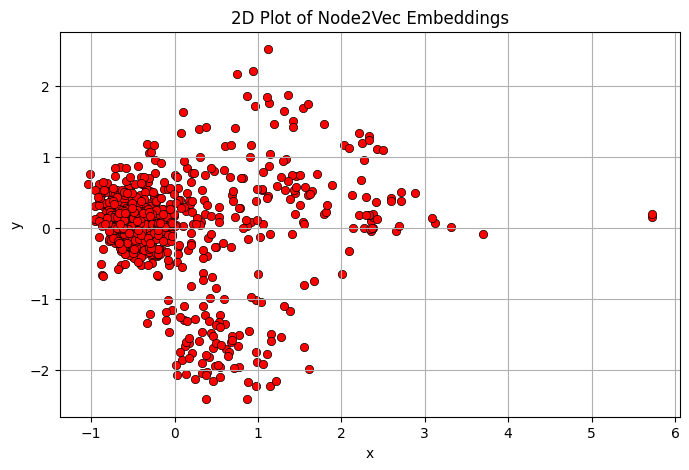

In [30]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca_embeddings(node_embeddings, n_components=2, title='2D Plot of Node2Vec Embeddings', color='red', edgecolor='black', lw=0.5):
    """
    Perform PCA on node embeddings and plot the reduced dimensions.

    :param node_embeddings: A list or array of node embeddings.
    :param n_components: The number of principal components to reduce to.
    :param title: Title for the plot.
    :param color: Color of the points in the scatter plot.
    :param edgecolor: Color of the edge around each point in the scatter plot.
    :param lw: Line width of the edge around the scatter plot points.
    """
    # Dimensionality Reduction with PCA
    pca = PCA(n_components=n_components)
    node_embeddings_reduced = pca.fit_transform(node_embeddings)

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.scatter(node_embeddings_reduced[:, 0], node_embeddings_reduced[:, 1], marker='o', color=color, edgecolors=edgecolor, lw=lw)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming node_embeddings_1 and a method to extract embeddings exist
keys = list(node_embeddings_1.key_to_index.keys())
node_embeddings = [node_embeddings_1[key] for key in keys]
plot_pca_embeddings(node_embeddings)


In [31]:
node_embeddings_2d.dtype

dtype('float64')

In [32]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA

def plot_3d_pca_embeddings(node_embeddings, title='3D Plot of Node2Vec Embeddings', color='red'):
    """
    Perform PCA on node embeddings to reduce to three dimensions and plot the result in a 3D scatter plot using Plotly.
    All points will be plotted in a single color.

    :param node_embeddings: A list or array of node embeddings.
    :param title: Title for the interactive plot.
    :param color: Color of the markers in the plot. Default is 'blue'.
    """
    # Dimensionality Reduction with PCA
    pca = PCA(n_components=3)
    node_embeddings_3d = pca.fit_transform(node_embeddings)

    x = node_embeddings_3d[:, 0]
    y = node_embeddings_3d[:, 1]
    z = node_embeddings_3d[:, 2]

    # Create a Plotly figure
    fig = go.Figure(data=[go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=5,
            color=color,  # Single color for all points
            opacity=0.8,
            line=dict(color='black', width=0.5)  # Edge line for markers
        )
    )])

    # Update plot layout
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        margin=dict(l=0, r=0, b=0, t=0),  # Adjust margins to fit the layout
        width=1000,  # width in pixels equivalent to 10 inches if 100 px/inch
        height=800   # height in pixels equivalent to 8 inches
    )

    # Show the plot
    fig.show()

# Example usage:
# Assuming 'node_embeddings' is already defined
plot_3d_pca_embeddings(node_embeddings)


In [33]:
pca_3d = PCA(n_components=3)
node_embeddings_3d = pca_3d.fit_transform(node_embeddings)

#### 3.3 Find Clusters using DBSCAN

In [34]:
node_embeddings = np.array(node_embeddings)
print(node_embeddings.shape)

(799, 64)


In [35]:
from sklearn.cluster import DBSCAN

# Create a DBSCAN model
dbscan = DBSCAN(eps=3, min_samples=5)

# Fit the model to your data
dbscan.fit(node_embeddings)

# Get the cluster labels for each point
labels = dbscan.labels_
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [36]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

def evaluate_dbscan_eps_range(data, eps_values, min_samples):
    """
    Evaluate DBSCAN over a range of eps values and return the clustering statistics.

    :param data: The dataset to cluster (as a numpy array).
    :param eps_values: A list of eps values to evaluate.
    :param min_samples: The minimum number of samples required for a core point.
    :return: A dictionary containing eps values and their corresponding cluster info.
    """
    results = {}
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data)
        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Exclude noise points
        num_noise = list(labels).count(-1)

        # Attempt to calculate silhouette score if more than one cluster and less than len(data)-1 noise points are found
        if num_clusters > 1 and num_noise < len(data) - 1:
            silhouette = silhouette_score(data, labels)
        else:
            silhouette = None  # Silhouette score is not meaningful in this context

        results[eps] = {
            'num_clusters': num_clusters,
            'num_noise': num_noise,
            'silhouette_score': silhouette
        }

    return results

# Example usage:
eps_values = np.arange(0.5, 2.5, 0.25)  # Adjust the range and step size based on your specific data
min_samples = 5   #rage from 5 to 15. best 10
results = evaluate_dbscan_eps_range(node_embeddings, eps_values, min_samples)

# Print the results
for eps, info in results.items():
    print(f"EPS: {eps}, Clusters: {info['num_clusters']}, Noise Points: {info['num_noise']}, Silhouette: {info['silhouette_score']}")


EPS: 0.5, Clusters: 1, Noise Points: 792, Silhouette: None
EPS: 0.75, Clusters: 1, Noise Points: 789, Silhouette: None
EPS: 1.0, Clusters: 3, Noise Points: 771, Silhouette: -0.220069020986557
EPS: 1.25, Clusters: 6, Noise Points: 747, Silhouette: -0.19992901384830475
EPS: 1.5, Clusters: 13, Noise Points: 668, Silhouette: -0.15408392250537872
EPS: 1.75, Clusters: 13, Noise Points: 602, Silhouette: -0.12843948602676392
EPS: 2.0, Clusters: 11, Noise Points: 380, Silhouette: -0.017138972878456116
EPS: 2.25, Clusters: 3, Noise Points: 199, Silhouette: 0.03332400321960449


Experimented with different values of `min_samples` from `5` to `20`. Best was `5`. Similarily best `eps=1.75`.

In [37]:
#find outliers where index value is -1
outlier_indices = [i for i, label in enumerate(labels) if label == -1]

print(f"Indices of outliers: {outlier_indices}")

Indices of outliers: [19, 20, 64, 94, 116, 131, 135, 148, 156, 167, 195, 231, 243, 254, 272, 301, 384, 502, 770]


In [38]:
keys[21], keys[23]

('1079', '1086')

In [39]:
node_embeddings_1.most_similar('1193')

[('1144', 0.9716622233390808),
 ('1088', 0.9621912837028503),
 ('1802', 0.8448038101196289),
 ('1950', 0.8260329365730286),
 ('1336', 0.8203996419906616),
 ('1346', 0.8176558613777161),
 ('1755', 0.812926709651947),
 ('2111', 0.8119850158691406),
 ('2012', 0.7744380235671997),
 ('1724', 0.7481116056442261)]

DBSCAN is not doing well on the data to find clusters. Let's use K-Means for the same.

#### 3.4 Find Clusters using K-Means

In [40]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_clusters = kmeans.fit_predict(node_embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



n_clusters = 2, Inertia = 4943.0009765625
n_clusters = 3, Inertia = 4643.8466796875
n_clusters = 4, Inertia = 4443.43017578125
n_clusters = 5, Inertia = 4337.783203125
n_clusters = 6, Inertia = 4231.6806640625
n_clusters = 7, Inertia = 4138.50537109375
n_clusters = 8, Inertia = 4024.96484375
n_clusters = 9, Inertia = 3972.607421875
n_clusters = 10, Inertia = 3890.19287109375


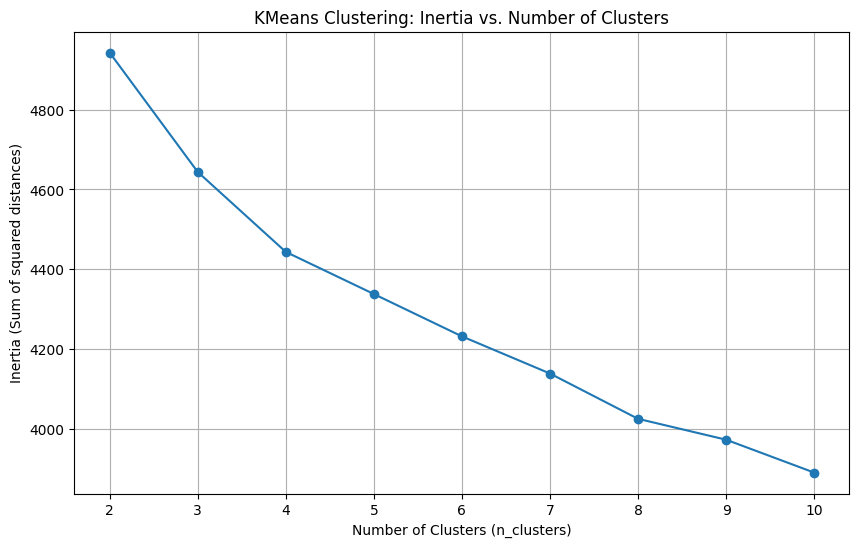

In [41]:
def evaluate_kmeans(node_embeddings, max_clusters=10, random_state=42, n_init=10, max_iter=500):
    """
    This function fits KMeans for a range of cluster numbers and plots the inertia to help determine the best number of clusters.

    :param node_embeddings: An array-like structure containing the node embeddings.
    :param max_clusters: The maximum number of clusters to test. The function will test from 2 up to max_clusters.
    :param random_state: The random state for KMeans to ensure reproducibility.
    :param n_init: Number of times the KMeans algorithm will run with different centroid seeds.
    """
    n_clusters_range = range(2, max_clusters + 1)  # Start from 2 to max_clusters
    inertia_values = []

    # Fit KMeans for each number of clusters and collect the inertia values
    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init, max_iter=max_iter)
        kmeans_clusters = kmeans.fit_predict(node_embeddings)
        inertia_values.append(kmeans.inertia_)
        print(f"n_clusters = {n_clusters}, Inertia = {kmeans.inertia_}")

    # Plotting the inertia values
    plt.figure(figsize=(10, 6))
    plt.plot(n_clusters_range, inertia_values, marker='o')
    plt.title('KMeans Clustering: Inertia vs. Number of Clusters')
    plt.xlabel('Number of Clusters (n_clusters)')
    plt.ylabel('Inertia (Sum of squared distances)')
    plt.grid(True)
    plt.xticks(n_clusters_range)
    plt.show()

# Example usage of the function
# Assuming node_embeddings is already loaded in your environment
evaluate_kmeans(node_embeddings=node_embeddings, max_clusters=10)


In [42]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_clusters = kmeans.fit_predict(node_embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [43]:
unique_labels, counts = np.unique(kmeans.labels_, return_counts=True)
print(unique_labels)
print(counts)

[0 1 2]
[ 99 589 111]


In [44]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_node_embeddings_2d(node_embeddings_2d, labels, colors=None):
    """
    Plots the 2D embeddings with color coding for clusters.

    :param node_embeddings_2d: A numpy array or list of lists containing the 2D embeddings.
    :param labels: A list or array of cluster labels corresponding to each embedding.
    :param colors: A dictionary mapping cluster labels to colors. Optional.
    """
    # Default colors if none are provided
    if colors is None:
        colors = {0: 'red', 1: 'green', 2: 'orange', 3: 'blue', 4: 'purple'}

    # Create a DataFrame
    df = pd.DataFrame(node_embeddings_2d, columns=['x', 'y'])
    df['Cluster'] = labels

    # Create a plot
    plt.figure(figsize=(8, 5))

    # Plot each cluster as a separate scatter plot
    for cluster in df['Cluster'].unique():
        cluster_data = df[df['Cluster'] == cluster]
        plt.scatter(
            cluster_data['x'],
            cluster_data['y'],
            c=colors.get(cluster, 'grey'),  # Use specified color or default to grey
            s=50,  # Marker size
            edgecolors='black',  # Black edge around each point
            label=f'Cluster {cluster}',
            lw=0.4
        )

    # Update plot layout
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(title='Clusters', loc='upper left')

    # Show the plot
    plt.show()


In [45]:
node_embeddings_2d

array([[ 0.08335   , -0.20175853],
       [ 0.13960926, -0.03167491],
       [-0.20080443, -0.03362088],
       [-0.06193098,  0.08808547],
       [-0.23294996, -0.12460078],
       [-0.12135659,  0.1062646 ],
       [ 0.11019681, -0.0854276 ],
       [-0.16785835,  0.31702   ],
       [ 0.38652507,  0.21374441],
       [ 0.06521917, -0.24803178]])

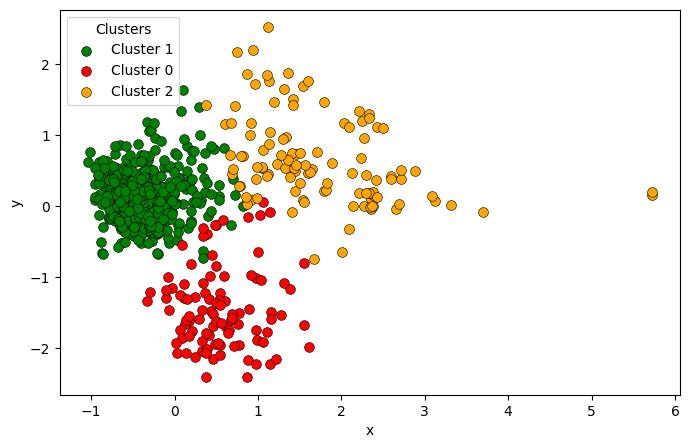

In [46]:
pca_2d = PCA(n_components=2)
node_embeddings_2d = pca_2d.fit_transform(node_embeddings)

plot_node_embeddings_2d(node_embeddings_2d, kmeans.labels_)

In [47]:
import plotly.graph_objects as go
import pandas as pd

def plot_3d_clusters(node_embeddings_3d, labels, colors=None, title='Node Clusters using K-Means'):
    """
    Function to plot 3D PCA-reduced embeddings with colors representing different clusters.

    :param node_embeddings_3d: A numpy array or list of lists containing the 3D embeddings.
    :param labels: A list or array of cluster labels corresponding to each embedding.
    :param colors: A dictionary mapping cluster labels to colors. Optional.
    :param title: Title of the plot. Default is 'Node Clusters using K-Means'.
    """
    # Create a DataFrame from the node embeddings and labels
    df = pd.DataFrame(node_embeddings_3d, columns=['X', 'Y', 'Z'])
    df['Cluster'] = labels

    # Default colors if none are provided
    if colors is None:
        colors = {0: 'red', 1: 'green', 2: 'orange'}

    # Create a plotly graph object figure
    fig = go.Figure()

    # Add scatter plots for each cluster
    for cluster in df['Cluster'].unique():
        cluster_data = df[df['Cluster'] == cluster]
        fig.add_trace(
            go.Scatter3d(
                x=cluster_data['X'],
                y=cluster_data['Y'],
                z=cluster_data['Z'],
                mode='markers',
                marker=dict(
                    size=5,
                    color=colors.get(cluster, 'grey'),  # Use specified color or default to grey
                    line=dict(
                        width=1,
                        color='black'  # Black edge around each point
                    )
                ),
                name=f'Cluster {cluster}'
            )
        )

    # Update plot layout
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        legend_title='Clusters'
    )

    # Show the plot
    fig.show()

# Example usage:
# Assuming 'node_embeddings_3d' and 'kmeans.labels_' are defined

In [48]:
plot_3d_clusters(node_embeddings_3d, kmeans.labels_)

Some statistics of the data after performing k-means clustering.

In [49]:
unique_labels, counts = np.unique(kmeans.labels_, return_counts=True)
print("Unique labels: ", unique_labels)
print("Counts for each label: ", counts)

node_labels = kmeans.labels_
node_labels.shape

Unique labels:  [0 1 2]
Counts for each label:  [ 99 589 111]


(799,)